In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import fetch_lfw_pairs
import os
import keras.backend as K
from keras.models import Model, Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Subtract, Lambda,Dropout,Concatenate,GlobalAveragePooling2D,BatchNormalization
from keras.optimizers import Adam, SGD , RMSprop
from keras.regularizers import l2
import keras.backend as K
from keras import activations
from keras import applications
import tensorflow as tf
import keras.backend as K
from keras.optimizers import Optimizer
import numpy as np
from keras.callbacks import EarlyStopping , ModelCheckpoint
from keras.initializers import RandomNormal
from keras.applications import ResNet50

In [ ]:
!pip install deepface

In [ ]:
from deepface import DeepFace

In [ ]:
net = DeepFace.OpenFace.loadModel()

In [ ]:
net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_69 (ZeroPadding2 (None, 102, 102, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_69[0][0]          
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
image_slice=(slice(70, 195), slice(65, 190))
from sklearn.datasets import fetch_lfw_pairs
lfw_pairs_train = fetch_lfw_pairs(subset='train',funneled=True,resize=96/125,slice_=image_slice,color=True)
lfw_pairs_test = fetch_lfw_pairs(subset='test',funneled=True,resize=96/125,slice_=image_slice,color=True)


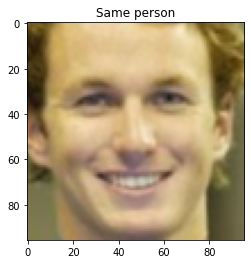

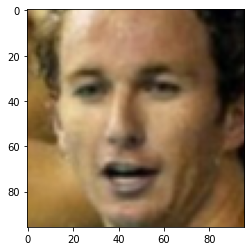

(96, 96, 3)


In [ ]:
ind=1
img1,img2=lfw_pairs_train.pairs[ind]
img1 = img1/255
img2 = img2/255
plt.title(lfw_pairs_train.target_names[lfw_pairs_train.target[ind]])
plt.imshow(img1)
plt.show()
plt.show()
plt.imshow(img2)
plt.show()
plt.show()
print(img1.shape)

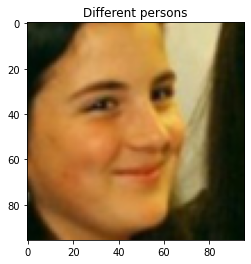

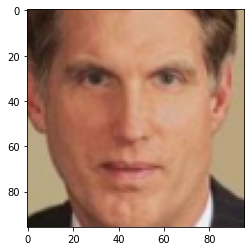

(96, 96, 3)


In [ ]:
ind=998
img1,img2=lfw_pairs_test.pairs[ind]
img1 = img1/255
img2 = img2/255
plt.title(lfw_pairs_test.target_names[lfw_pairs_test.target[ind]])
plt.imshow(img1)
plt.show()
plt.show()
plt.imshow(img2)
plt.show()
plt.show()
print(img1.shape)

In [ ]:
lfw_pairs_train.pairs.shape

(2200, 2, 96, 96, 3)

In [ ]:
A_train = []
B_train = []
y_train = list(lfw_pairs_train.target)
for i in lfw_pairs_train.pairs:
  A_train.append(i[0])
  B_train.append(i[1])

A_train = np.array(A_train)
B_train = np.array(B_train)
y_train = np.array(y_train)

In [ ]:
A_test = []
B_test = []
y_test = list(lfw_pairs_test.target)
for i in lfw_pairs_test.pairs:
  A_test.append(i[0])
  B_test.append(i[1])
  
A_test = np.array(A_test)
B_test = np.array(B_test)
y_test = np.array(y_test)

In [ ]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [ ]:
inputA = Input(shape=(96,96,3))
inputB = Input(shape=(96,96,3))

x = net(inputA)
x = Model(inputs=inputA, outputs=x)

y = net(inputB)
y = Model(inputs=inputB, outputs=y)

for i, layer in enumerate(y.layers):
    layer._name = 'layer_' + str(i)

# combined = Concatenate()([x.output, y.output])

def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = K.sum(K.square(featA - featB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

z = Lambda(euclidean_distance)([x.output, y.output])
z = Dense(1, activation="sigmoid")(z)

model = Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=SGD() ,metrics=['binary_accuracy'])

In [ ]:
model.fit(x=[A_test, B_test], y=y_test,validation_data=([A_train[:400], B_train[:400]], y_train[:400]),epochs=25,batch_size=8)

Epoch 1/25
125/125 [==============================] - 5s 43ms/step - loss: 0.4910 - binary_accuracy: 0.7670 - val_loss: 0.1251 - val_binary_accuracy: 0.9850
Epoch 2/25
125/125 [==============================] - 5s 43ms/step - loss: 0.3808 - binary_accuracy: 0.8370 - val_loss: 0.1009 - val_binary_accuracy: 0.9950
Epoch 3/25
125/125 [==============================] - 5s 43ms/step - loss: 0.2993 - binary_accuracy: 0.8840 - val_loss: 0.1059 - val_binary_accuracy: 0.9925
Epoch 4/25
125/125 [==============================] - 5s 43ms/step - loss: 0.2658 - binary_accuracy: 0.9150 - val_loss: 0.1070 - val_binary_accuracy: 0.9900
Epoch 5/25
125/125 [==============================] - 5s 42ms/step - loss: 0.2189 - binary_accuracy: 0.9490 - val_loss: 0.1109 - val_binary_accuracy: 0.9900
Epoch 6/25
125/125 [==============================] - 5s 42ms/step - loss: 0.2018 - binary_accuracy: 0.9580 - val_loss: 0.1094 - val_binary_accuracy: 0.9875
Epoch 7/25
125/125 [==============================] - 5s 4

In [ ]:
model.save("face_ver2.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MIP
model = load_model("face_ver2.h5")
from PIL import Image
def pre_process(path):
  im = Image.open(path)
  out = im.resize((96,96))
  out = np.expand_dims(out, axis=0)
  return np.array(out)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MIP


In [ ]:
x ="lfw/Akhmed_Zakayev/Akhmed_Zakayev_0002.jpg"
y = "lfw/Akhmed_Zakayev/Akhmed_Zakayev_0003.jpg"

In [ ]:
predictions = model.predict([A_train[400:], B_train[400:]])

In [ ]:
def accuracy(predictions,actual,threshold):
  l = len(actual)
  correct = 0
  for i in range(len(predictions)):
    a=0
    b=0
    if predictions[i]>threshold:
      a=1
    else:
      a=0
    if actual[i]>threshold:
      b=1
    else:
      b=0
    if(a==b):
      correct = correct + 1
  return correct/l

In [ ]:
print("Accuracy when Threshold is 0.5 : ",accuracy(predictions,y_train[400:],0.5))
print("Accuracy when Threshold is 0.6 : ",accuracy(predictions,y_train[400:],0.6))
print("Accuracy when Threshold is 0.65 : ",accuracy(predictions,y_train[400:],0.65))
print("Accuracy when Threshold is 0.7 : ",accuracy(predictions,y_train[400:],0.7))
print("Accuracy when Threshold is 0.75 : ",accuracy(predictions,y_train[400:],0.75))

Accuracy when Threshold is 0.5 :  0.975
Accuracy when Threshold is 0.6 :  0.9777777777777777
Accuracy when Threshold is 0.65 :  0.9777777777777777
Accuracy when Threshold is 0.7 :  0.9755555555555555
Accuracy when Threshold is 0.75 :  0.9727777777777777
